In [1]:
import numpy as np
from numpy.linalg import norm
import math
from urllib.request import urlopen
import json
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from urllib.request import urlopen
import random

import urllib
import scipy.optimize
import random
from collections import defaultdict # Dictionaries with default values
import nltk
from nltk.util import ngrams
import string
from nltk.stem.porter import *
import ast
from nltk.corpus import stopwords

import gzip
from collections import defaultdict

# nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

In [2]:
# Parse each json object
def read_JSON(path):
    for l in gzip.open(path, 'r'):
        yield json.loads(l)

## 1. Dataset Exploratory Analysis

Dataset: https://cseweb.ucsd.edu/~jmcauley/datasets.html#clothing_fit (Rent The Runway)

In [31]:
# Load data
data = []
for d in read_JSON('renttherunway_final_data.json.gz'):
    data.append(d)

# Filter data without a rating
for d in data:
    if not d['rating']:
        data.remove(d)

###  Basic Statistics and Properties

In [32]:
# Size of dataset
print("Size of original data set =", len(data), "samples")

# Number of features
print("Number of features =", len(data[0]), "features")

Size of original data set = 192462 samples
Number of features = 15 features


In [34]:
# Example sample
data[0]

{'fit': 'fit',
 'user_id': '420272',
 'bust size': '34d',
 'item_id': '2260466',
 'weight': '137lbs',
 'rating': '10',
 'rented for': 'vacation',
 'review_text': "An adorable romper! Belt and zipper were a little hard to navigate in a full day of wear/bathroom use, but that's to be expected. Wish it had pockets, but other than that-- absolutely perfect! I got a million compliments.",
 'body type': 'hourglass',
 'review_summary': 'So many compliments!',
 'category': 'romper',
 'height': '5\' 8"',
 'size': 14,
 'age': '28',
 'review_date': 'April 20, 2016'}

In [35]:
# Split training and test data
# random.shuffle(data)
training_data = data[:150000]
test_data = data[150000:]

len(test_data)

42462

### Feature Categories

* Categorical Features: fit, user_id, bust_size, item_id, rented_for, category, body_type, review_date

* Numerical Features: weight, size, height, age

* Ordinal Features: rating, review_text, review_summary

### Feature Exploration

In [38]:
# For categorical features determine options
fit_options = set()
rental_reasons = set()
body_types = set()
clothing_categories = set()

for d in training_data:
    fit_options.add(d['fit'])
    if 'rented for' in d:
        rental_reasons.add(d['rented for'])
    if 'body type' in d:
        body_types.add(d['body type'])
    clothing_categories.add(d['category'])

In [45]:
print("Fit Options: ", ', '.join(fit_options), "\n")
print("Rental Reasons: ", ', '.join(rental_reasons), "\n")
print("Body Types: ", ', '.join(body_types), "\n")
print("Clothing Categories: ", ', '.join(clothing_categories), "\n")

Fit Options:  large, fit, small 

Rental Reasons:  date, everyday, party: cocktail, wedding, vacation, other, work, formal affair, party 

Body Types:  straight & narrow, pear, athletic, apple, petite, full bust, hourglass 

Clothing Categories:  culottes, print, duster, pants, shift, combo, crewneck, jeans, tee, hoodie, gown, sweatpants, cami, skirt, t-shirt, peacoat, cardigan, shirtdress, trouser, skirts, tunic, tight, trousers, maxi, culotte, overalls, poncho, pullover, overcoat, knit, leggings, top, dress, blouson, suit, jacket, down, coat, tank, pant, blazer, trench, vest, henley, turtleneck, jogger, parka, buttondown, sweatshirt, kaftan, for, skort, romper, shirt, ballgown, sweatershirt, sweater, legging, jumpsuit, caftan, cape, bomber, mini, sheath, frock, midi, kimono, blouse 



In [51]:
# Determine # entries without 'rented for'
missing_rent_reason_count = 0
missing_body_type_count = 0
missing_age_count = 0
for d in training_data:
    if 'rented for' not in d:
        missing_rent_reason_count += 1
    if 'body type' not in d:
        missing_body_type_count += 1
    if 'age' not in d:
        missing_age_count += 1

print("Entries missing rental reason:", missing_rent_reason_count, "/", len(training_data))
print("Entries missing body type:", missing_body_type_count, "/", len(training_data))
print("Entries missing age:", missing_age_count, "/", len(training_data))

Entries missing rental reason: 9 / 150000
Entries missing body type: 11358 / 150000
Entries missing age: 742 / 150000


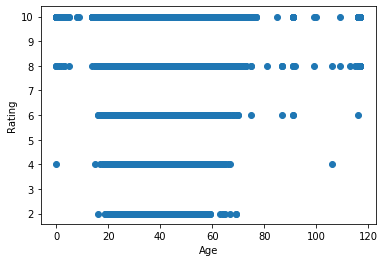

In [54]:
# Plot Age vs Rating
age_vs_rating = np.zeros((len(training_data) - missing_age_count, 2))

i = 0
for d in training_data:
    if 'age' in d:
        age_vs_rating[i][0] = d['age']
        age_vs_rating[i][1] = d['rating']
        i+=1
        
plt.scatter(age_vs_rating[:,0], age_vs_rating[:,1])
plt.xlabel('Age')
plt.ylabel('Rating')
plt.show()

#### Analysis of Age vs Rating
Age versus Rating graph shows age alone is not a strong indicator of rating. Note that individuals of extreme ages (<20 and >80) tend to give higher ratings

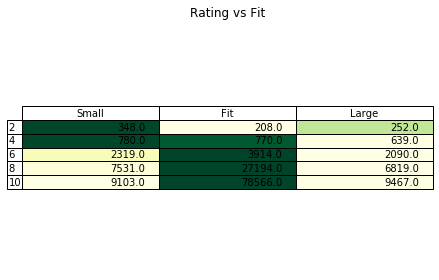

In [145]:
# Plot Rating vs Fit
fit_vs_rating_counts = np.zeros((5, 3))


fitDict = {
  "small": 0,
  "fit": 1,
  "large": 2,
}

ratingDict = {
    '2': 0,
    '4': 1,
    '6': 2,
    '8': 3,
    '10': 4,
}


for d in training_data:
    fit_vs_rating_counts[ratingDict[d['rating']]][fitDict[d['fit']]]+=1

idx = pd.Index(np.arange(2,11, 2))
df = pd.DataFrame(fit_vs_rating_counts, index=idx, columns=['Small', 'Fit', 'Large'])
vals = np.around(df.values,2)

colours = np.zeros((5,3,4))
for i in range(0, 5):
    norm = plt.Normalize(vals[i,:].min()-1, vals[i,:].max()+1)
    colours[i,:] = plt.cm.YlGn(norm(vals[i,:]))

fig, ax = plt.subplots()

# hide axes
fig.patch.set_visible(False)
ax.axis('off')
ax.axis('tight')
ax.set_title('Rating vs Fit')
ax.table(cellText=df.values, colLabels=df.columns, rowLabels=df.index, loc='center', cellColours=colours)
fig.tight_layout()
plt.show()


#### Analysis of Rating vs Fit
TODO

## 2. Predictive Task

### About

Our predictive task is predicting a user's rating on a review of their clothing fit on some given features. 

### Baseline Models

One naive baseline predictive model we can use is simply determining if the customer considered the clothing item as "fit", which means the item was neither "small" nor "large". This is a good sign the the customer was satisfied, so we simply guess the rating to be "10". Otherwise we guess a random lesser rating from all other possible ratings in the training data. To get these other ratings, we iterated through the training data, and put them in a set.

Another naive baseline we can do is selectively find the most common words that are not stop-words used in each rating category. For example, in a "10" words that appear may be "perfect" or "great". We can manually select qualitative words for each category, and our predictor would simply predict that rating if those words appear in a review. We found these words by finding the top 30 most frequent non-stop-words for each rating category in the training data. For reviews that have overlapping words in multiple rating categories, the higher rating category would take precedence.

#### Baseline 1: Predict a rating of 10 if the fit = 'fit', otherwise randomly predict a rating in the range of all other rating in the data set

In [39]:
# Find ratings that aren't 10
other_ratings = set()
for d in data:
    if d['rating'] != '10':
        other_ratings.add(d['rating'])
print("Set of other ratings:", other_ratings)

def baseline1(data, y):
    predictions = []
    for d in data:
        if d['fit'] == 'fit':
            predictions.append('10')
        else:
            predictions.append(random.choice(list(other_ratings)))
    return predictions

y_test = [d['rating'] for d in test_data]
predictions = baseline1(test_data, y_test)
correct = [y_test[i] == predictions[i] for i in range(len(y_test))]
print("Accuracy =", sum(correct) / len(y_test))

Set of other ratings: {'4', '2', '6', '8'}
Accuracy = 0.5571569874240497


#### Baseline 2: Predict based on specific words that appear in the review

In [40]:
# Baseline 2 preparation: Find most common words that aren't stop words
punct = string.punctuation

r2_word_count = defaultdict(int)
r4_word_count = defaultdict(int)
r6_word_count = defaultdict(int)
r8_word_count = defaultdict(int)
r10_word_count = defaultdict(int)

rating_count = defaultdict(int)
for d in data:
    t = d['review_text']
    t = t.lower() # lowercase string
    t = [c for c in t if not (c in punct)] # Non-punct characters
    t = ''.join(t) # Convert back to string
    words = t.strip().split() # Tokenizes
    
    rating_count[d['rating']] += 1
    for w in words:
        if w not in stop_words:
            if d['rating'] == '2':
                r2_word_count[w] += 1
            elif d['rating'] == '4':
                r4_word_count[w] += 1
            elif d['rating'] == '6':
                r6_word_count[w] += 1
            elif d['rating'] == '8':
                r8_word_count[w] += 1
            elif d['rating'] == '10':
                r10_word_count[w] += 1

def top_words(word_count):
    counts = [(word_count[w], w) for w in word_count]
    counts.sort()
    counts.reverse()
    return [w[1] for w in counts[:30]]

print("Most frequent words per category")
word_counts = [(2, r2_word_count), (4, r4_word_count), (6, r6_word_count), (8, r8_word_count), (10, r10_word_count)]
for rating, count in word_counts:
    print(rating, ":", top_words(count), "\n")

rating_count = [(rating_count[w], w) for w in rating_count]
rating_count.sort()
rating_count.reverse()
print("Most common rating: " + rating_count[0][1])

Most frequent words per category
2 : ['dress', 'wear', 'fit', 'size', 'would', 'like', 'didnt', 'even', 'small', 'way', 'look', 'short', 'really', 'big', 'im', 'looked', 'wearing', 'tight', 'long', 'made', 'back', 'large', 'could', 'top', 'material', 'fabric', 'also', 'chest', 'couldnt', 'ordered'] 

4 : ['dress', 'fit', 'wear', 'size', 'would', 'didnt', 'like', 'really', 'small', 'look', 'top', 'wearing', 'short', 'also', 'tight', 'way', 'fabric', 'im', 'back', 'long', 'even', 'big', 'looked', 'waist', 'large', 'made', 'material', 'could', 'pretty', 'great'] 

6 : ['dress', 'fit', 'would', 'size', 'wear', 'didnt', 'little', 'like', 'really', 'top', 'great', 'bit', 'look', 'small', 'short', 'tight', 'also', 'im', 'fabric', 'long', 'wearing', 'waist', 'color', 'pretty', 'back', 'wore', 'beautiful', 'work', 'made', 'big'] 

8 : ['dress', 'fit', 'size', 'would', 'little', 'wear', 'great', 'wore', 'bit', 'comfortable', 'loved', 'compliments', 'perfect', 'really', 'like', 'im', 'didnt', 'lo

In [41]:
def baseline2(data, y):
    predictions = []
    for d in data:
        # If no review, just choose most common in training set
        if not d['review_text']: # if "review_text" not in d
            predictions.append('10')
            continue
        t = d['review_text']
        t = t.lower() # lowercase string
        t = [c for c in t if not (c in punct)] # Non-punct characters
        t = ''.join(t) # Convert back to string
        words = t.strip().split() # Tokenizes
        if "perfect" in words:
            predictions.append(str(rating_count[0][1]))
        elif "great" in words:
            predictions.append('8')
        elif "little" in words:
            predictions.append('6')
        elif "didnt" in words:
            predictions.append('4')
        elif "couldnt" in words:
            predictions.append('2')
        else:
            predictions.append(str(rating_count[0][1])) # Most common
    return predictions
            
y_test = [d['rating'] for d in test_data]
predictions = baseline2(test_data, y_test)
correct = [y_test[i] == predictions[i] for i in range(len(y_test))]
print("Accuracy =", sum(correct) / len(y_test))

Accuracy = 0.49053271160096085


### Logistic Regression

For our focal predictors, we decided to train logistic regressors with other features // TODO:

We can validify our predictions by // TODO: Our baselines were in the 50-60% accuracy range, which is decent considering there are 5 possible predictions.

#### Primary 1: Try logistic regressor that just takes into account the length of a review

In [42]:
def length_feature(datum):
    return [1, len(datum['review_text'])]

X = [length_feature(d) for d in training_data]    
y = [d['rating'] for d in training_data]
model = linear_model.LogisticRegression(max_iter=10000)
model.fit(X, y)

X_test = [length_feature(d) for d in test_data] 
y_test = [d['rating'] for d in test_data]
predictions = model.predict(X_test)
correct = [y_test[i] == predictions[i] for i in range(len(y_test))]
print("Accuracy =", sum(correct) / len(y_test))

Accuracy = 0.6453063915971928


#### Primary 2: Try logistic regressor with features weight, review_text, fit

In [43]:
word_count = defaultdict(int)
total_words = 0

rented_for_set = set()
fit_set = set()

for d in training_data:
    if 'rented for' in d:
        rented_for_set.add(d['rented for'])
    if 'fit' in d:
        fit_set.add(d['fit'])
    t = d['review_text']
    t = t.lower() # lowercase string
    t = [c for c in t if not (c in punct)] # non-punct characters
    t = ''.join(t) # convert back to string
    words = t.strip().split() # tokenizes
    for w in words:
        if w not in stop_words:
            total_words += 1
            word_count[w] += 1

rented_for_ID = dict(zip(list(rented_for_set), range(len(rented_for_set))))
fit_ID = dict(zip(list(fit_set), range(len(fit_set))))

print(rented_for_ID)
print()
print(fit_ID)

{'formal affair': 0, 'work': 1, 'other': 2, 'vacation': 3, 'party: cocktail': 4, 'party': 5, 'date': 6, 'wedding': 7, 'everyday': 8}

{'fit': 0, 'small': 1, 'large': 2}


In [44]:
counts = [(word_count[w], w) for w in word_count]
counts.sort()
counts.reverse()
counts[:10]
print(len(counts))

words = [w[1] for w in counts[:1400]]
word_ID = dict(zip(words, range(len(words))))
word_set = set(words)
print(len(word_set))

def dictionary_feature(datum):
    feat = [0]*len(word_set)
    t = datum['review_text']
    t = t.lower() # lowercase string
    t = [c for c in t if not (c in punct)] # non-punct characters
    t = ''.join(t) # convert back to string
    words = t.strip().split() # tokenizes
    for w in words:
        if not (w in word_set): continue
        feat[word_ID[w]] += 1
    # Get One-hot-encoding for 'rented for' and 'fit'
    rented_for_OHE = [0] * len(rented_for_ID)
    fit_OHE = [0] * len(fit_ID)
    if 'rented for' in datum and datum['rented for'] in rented_for_ID:
        rented_for_OHE[rented_for_ID[datum['rented for']]] = 1
    if 'fit' in datum and datum['fit'] in fit_ID:
        fit_OHE[fit_ID[datum['fit']]] = 1
    feat += rented_for_OHE + fit_OHE
    feat.append(1)
    return feat

42863
1750


In [45]:
X_train = [dictionary_feature(d) for d in training_data]
y_train = [d['rating'] for d in training_data]

model = linear_model.LogisticRegression(C=1, solver='lbfgs', multi_class='auto', max_iter=10000)
model.fit(X_train, y_train)

X_test = [dictionary_feature(d) for d in test_data] 
y_test = [d['rating'] for d in test_data]
predictions = model.predict(X_test)
print(sum(predictions == y_test) / len(y_test))

0.6980829918515379


#### Primary 3: Try logistic regressor with features weight, review_text, fit

In [46]:
word_count = defaultdict(int)
total_words = 0

rented_for_set = set()
fit_set = set()

for d in training_data:
    if 'rented for' in d:
        rented_for_set.add(d['rented for'])
    if 'fit' in d:
        fit_set.add(d['fit'])
    t = d['review_summary']
    t = t.lower() # lowercase string
    t = [c for c in t if not (c in punct)] # non-punct characters
    t = ''.join(t) # convert back to string
    words = t.strip().split() # tokenizes
    for w in words:
        if w not in stop_words:
            total_words += 1
            word_count[w] += 1

rented_for_ID = dict(zip(list(rented_for_set), range(len(rented_for_set))))
fit_ID = dict(zip(list(fit_set), range(len(fit_set))))

print(rented_for_ID)
print()
print(fit_ID)

{'formal affair': 0, 'work': 1, 'other': 2, 'vacation': 3, 'party: cocktail': 4, 'party': 5, 'date': 6, 'wedding': 7, 'everyday': 8}

{'fit': 0, 'small': 1, 'large': 2}


In [47]:
counts = [(word_count[w], w) for w in word_count]
counts.sort()
counts.reverse()
counts[:10]
print(len(counts))

words = [w[1] for w in counts[:1500]]
word_id = dict(zip(words, range(len(words))))
word_set = set(words)
print(len(word_set))

def dictionary_summary_feature(datum):
    feat = [0]*len(word_set)
    t = datum['review_text']
    t = t.lower() # lowercase string
    t = [c for c in t if not (c in punct)] # non-punct characters
    t = ''.join(t) # convert back to string
    words = t.strip().split() # tokenizes
    for w in words:
        if not (w in word_set): continue
        feat[word_id[w]] += 1
    # Get One-hot-encoding for 'rented for' and 'fit'
    rented_for_OHE = [0] * len(rented_for_ID)
    fit_OHE = [0] * len(fit_ID)
    if 'rented for' in datum and datum['rented for'] in rented_for_ID:
        rented_for_OHE[rented_for_ID[datum['rented for']]] = 1
    if 'fit' in datum and datum['fit'] in fit_ID:
        fit_OHE[fit_ID[datum['fit']]] = 1
    feat += rented_for_OHE + fit_OHE
    feat.append(1)
    return feat

13462
1500


In [48]:
X_train = [dictionary_summary_feature(d) for d in training_data]
y_train = [d['rating'] for d in training_data]

model = linear_model.LogisticRegression(C=1, solver='lbfgs', multi_class='auto', max_iter=10000)
model.fit(X_train, y_train)

X_test = [dictionary_summary_feature(d) for d in test_data] 
y_test = [d['rating'] for d in test_data]
predictions = model.predict(X_test)
print(sum(predictions == y_test) / len(y_test))

0.697376477791908


## 3. Justification for Proposed Model, Optimizations, Issues, Model Alternatives

## 4. Literature Description

The data was orignally scraped by Rishabh Misra, Mengting Wan, and Julian McAuley, all affiliated with the University of California, San Diego. It was used for a paper titled *Decomposing Fit Semantics for Product Size Recommendation in Metric Spaces* which gave insight in how to tackle the product fit problem for online clothing retailers, to decrease the amount of return rates, which can be expensive. One of the datasets in the paper was our dataset, which were fit reviews obtained from *RentTheRunWay*, which is an online company that rents designer clothing and accessories.

Another dataset used in the paper is from *ModCloth*, which was used in the same way. Together these datasets were used with techniques that include "Learning Fit Semantics" and "Metric Learning". The results were effective, showing high AUC correctness with the predictive models.

Another paper, *SizeNet: Weakly Supervised Learning of Visual Size and Fit in Fashion Images* by Nour Karessli, Romain Guigoures, and Reza Shirvany, tackled this problem with other approaches with both quantitave and qualitative methods "Teacher-Student Learning" and "Statistical Modeling." Instead of data mining, they used more of a computer vision approach that analyzed images to determine how likely an item was to fit with the developed *SizeNet*.

These works are different from our own findings, because our goals are different. While they are trying to model how well a clothing item fits, we are simply guessing how a user would rate how well a clothing item fits from previous purchases/rentals. Interestingly, we had similar results to the UCSD study with respect to accuracy. Other models that would compare better to ours would be our own predictive tasks to determine ratings that we have done from our previous class assignments, such as the ones performed on the beer and steam review datasets, which all performed at around a 70% accuracy like ours, using similar techniques.

## 5. Results and Conclusions

### Citations:

#### Decomposing fit semantics for product size recommendation in metric spaces

Rishabh Misra, Mengting Wan, Julian McAuley

*RecSys, 2018*

http://cseweb.ucsd.edu/~jmcauley/pdfs/recsys18e.pdf

#### SizeNet: Weakly Supervised Learning of Visual Size and Fit in Fashion Images

Nour Karessli, Romain Guigoures, Reza Shirvany

*Zalando SE, 2019*

https://arxiv.org/abs/1905.11784